# fonte:
# https://colab.research.google.com/drive/19ulJqMQqk4PfcTx1v3C3cxjvzokrKgZS?usp=sharing#scrollTo=g04OdKntfzG5

# Image recognition with Python, OpenCV, OpenAI CLIP model and PostgreSQL `pgvector`

This repository contains the working code for the example in the [blog post](https://aiven.io/developer/find-faces-with-pgvector)

The below is the overall flow:

![Overall flow](https://github.com/Aiven-Labs/pgvector-image-recognition/blob/main/entire_flow.jpg?raw=1)

## Step 0: Install requirements


In [ ]:
'''

%pip install scikit-learn
%pip install tensorflow==2.18.0
%pip install gputil
%pip install pandas
%pip install tqdm
%pip install matplotlib
'''
%pip install opencv-python imgbeddings psycopg2-binary


Note: you may need to restart the kernel to use updated packages.


## Step 1: Face recognition

Detect the faces from the [test-image](test-image.png) picture and store them under the `stored-faces` folder

In [36]:
# importing the cv2 library
import cv2

# loading the haar case algorithm file into alg variable
alg = "./haarcascade_frontalface_default.xml"
# passing the algorithm to OpenCV
haar_cascade = cv2.CascadeClassifier(alg)
# loading the image path into file_name variable - replace <INSERT YOUR IMAGE NAME HERE> with the path to your image
file_name = "./R.jpeg"
# reading the image
img = cv2.imread(file_name, 0)
# creating a black and white version of the image
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# detecting the faces
faces = haar_cascade.detectMultiScale(
    gray_img, scaleFactor=1.05, minNeighbors=2, minSize=(100, 100)
)

i = 0
# for each face detected
for x, y, w, h in faces:
    # crop the image to select only the face
    cropped_image = img[y : y + h, x : x + w]
    # loading the target image path into target_file_name variable  - replace <INSERT YOUR TARGET IMAGE NAME HERE> with the path to your target image
    target_file_name = 'stored-faces/' + str(i) + '.jpg'
    cv2.imwrite(
        target_file_name,
        cropped_image,
    )
    i = i + 1;

## Step 2: Embeddings Calculation

Calculate embeddings from the faces and pushing to PostgreSQL, you'll need to change the `<SERVICE_URI>` parameter with the PostgreSQL Service URI

In [37]:
'''%pip show huggingface_hub
%pip install imgbeddings
%pip show imgbeddings'''


'%pip show huggingface_hub\n%pip install imgbeddings\n%pip show imgbeddings'

In [38]:
import numpy as np
from PIL import Image
import psycopg2
import os
from imgbeddings import imgbeddings

In [39]:
# importing the required libraries

# connecting to the database - replace the SERVICE URI with the service URI
conn = psycopg2.connect("dbname='postgres' user='user' host='localhost' password='password' port='5555'")
# creating the table
cur = conn.cursor()
cur.execute("CREATE EXTENSION IF NOT EXISTS vector")
cur.execute(
    "CREATE TABLE IF NOT EXISTS imgs (filename TEXT PRIMARY KEY, embeddings vector(768))"
)
conn.commit()


for filename in os.listdir("stored-faces"):
    # opening the image
    img = Image.open("stored-faces/" + filename)
    # loading the `imgbeddings`
    ibed = imgbeddings()
    # calculating the embeddings
    embedding = ibed.to_embeddings(img)
    cur = conn.cursor()
    cur.execute(
        "INSERT INTO imgs (filename, embeddings) VALUES (%s, %s) ON CONFLICT (filename) DO NOTHING",
        (filename, embedding[0].tolist())
    )
    print(filename)
conn.commit()

/home/bernardo/Documentos/github/face-recognition/.venv/lib/python3.10/site-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


4.jpg
1.jpg
3.jpg
2.jpg
0.jpg


## Step 3: Calculate embeddings on a new picture

Find the face and calculate the embeddings on the picture `solo-image.png` used for research

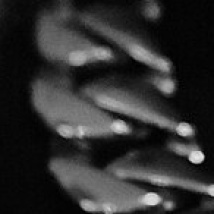

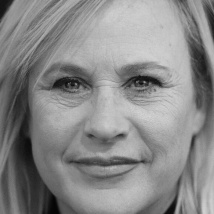

In [88]:
from PIL import Image

# loading the face image path into file_name variable
file_name = "./PatriciaArquette.jpg"  # replace <INSERT YOUR FACE FILE NAME> with the path to your image
img = cv2.imread(file_name, 0)
# creating a black and white version of the image
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# detecting the faces
faces = haar_cascade.detectMultiScale(
    gray_img, scaleFactor=1.05, minNeighbors=2, minSize=(100, 100)
)
for idx, face in enumerate(faces):
    x, y, w, h = face
    # crop the image to select only the face
    cropped_image = img[y : y + h, x : x + w]
    # loading the target image path into target_file_name variable
    cropped_image = cv2.resize(cropped_image, (214, 214), interpolation=cv2.INTER_AREA)
    target_file_name = f"target_face_{idx}.jpg"
    cv2.imwrite(
        target_file_name,
        cropped_image,
    )
    display(Image.open(target_file_name))


# Escolha o arquivo entre as target_face encontradas

/home/bernardo/Documentos/github/face-recognition/.venv/lib/python3.10/site-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


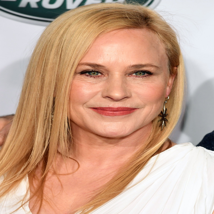

In [95]:
from PIL import Image
# opening the image
img = Image.open("PatriciaArquette.jpeg")
img = img.resize((214, 214))
# loading the `imgbeddings`
ibed = imgbeddings()
# calculating the embeddings
embedding = ibed.to_embeddings(img)
display(img)

## Step 3: Find similar images by querying the Postgresql database using pgvector

Similarity: 78.99%


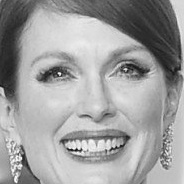

In [96]:
from IPython.display import Image, display
from sklearn.metrics.pairwise import cosine_similarity

# Rollback any previous transaction that might have failed
conn.rollback()

cur = conn.cursor()
string_representation = "["+ ",".join(str(x) for x in embedding[0].tolist()) +"]"
cur.execute("SELECT * FROM imgs ORDER BY embeddings <-> %s LIMIT 1;", (string_representation,))
rows = cur.fetchall()
for row in rows:
    stored_embedding = np.array(eval(row[1]))
    similarity = cosine_similarity([embedding[0]], [stored_embedding])[0][0]
    percentage_similarity = similarity * 100
    print(f"Similarity: {percentage_similarity:.2f}%")
    display(Image(filename="stored-faces/"+row[0]))
cur.close()